# Tutorial on neuronal package

**names: Amelia Paine, Han Sae Jung**

## Motivation

Commonly, electrophysiological data is processed by a bandpass filter and a moving average. Afterwards, neuronal signals are detected by thresholding or template-based methods. Then, the peak amplitudes of the identified spikes are quantified by simply subtracting the peak of the signal from the baseline. While these methods are computationally effective and have become a standard protocol for analyzing electrophysiological data, they render phase distortions to the signals to a certain extent; hence, we lose some information about the signals along the way.

Our goal is to analyze these data in a more statistically rigorous manner. Starting with the generative model proposed by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**), we will first infer the spike timings and peak amplitudes of postsynaptic potentials (PSP) in a Bayesian manner. Afterwards, we will modify the model in a way that accounts for action potentials (AP) as well. Additionally, we will work on resolving complications that arise from real electrophysiological data (e.g. varying baseline).

## Generative Model 

Our model is adapted/modified from the model suggested by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**)

The simplest version of our model is the following:

$$y_t = \sum_{i=1}^{n} a_i f_i(t - t_i) + b + \epsilon_t$$

$$f_i(t) = (\exp(-t / \tau_i^d) - \exp(-t / \tau_i^r)) \: \text{for} \: t \ge 0$$ 

$$\epsilon_t = \sum_{j=1}^{p} \phi_j \epsilon_{t-j} + u_t , \: u_t \approx N(0, \sigma^2)$$ 

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$, 

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSP's}$, 

$b \equiv \text{constant baseline}$, 

$f_i(t) \equiv \text{mathematical trial function of PSP}$, 

$\epsilon_t \equiv \text{general AR(p) autoregressive model of the noise}$, 

$u_t \equiv \text{Gaussian noise}$, 

$\tau_i^d \equiv \text{decay time constant}$, 

$\tau_i^r \equiv \text{rise time constant}$, 

$a_i \equiv \text{constant related to the peak amplitude of each PSP}$

By differentiating $f_i(t)$ with respect to $t$, we find that the maximum of the signal occurs at $t_i = t_i^*$:

$$t_i^* = \frac{ln(\tau_i^d / \tau_i^r)}{1 / \tau_i^r - 1 / \tau_i^d}$$

Then, 

$$a_i^{peak} = a_i \cdot f_i(t=t^*)$$

In order for our model to be successful, we need to somehow account for the following noise sources:

**examples of noise sources: electrical hardware, analog to digital conversion, membrane oscillations and local field potential from other neurons (not immediately adjacent to the electrode from which we are measuring), solution in which neurons are cultured, changes in resistance between the electrode and the interior of the neuron**

Since our noise is a mixture of a wide range of sources, we can argue that Gaussian i.i.d. noise model can be valid (on the basis of central limit theorem) to a certain extent. However, for a more accurate description of the noise process, we will account for the correlations in the noise by modeling the noise as an autoregressive AR(p) process. 

For AR(0) case (Gaussian i.i.d. noise), our likelihood function is:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y_t})^2}{2\sigma^2}\right)$$

where $\hat{y_t}$ refers to the predicted noiseless trace:

$$\hat{y_t} = \sum_{i=1}^{n} a_i f_i(t - t_i) + b$$

We can extend this to a more general AR(p) case:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y}_{t|t-1})^2}{2\sigma^2}\right)$$

where $\hat{y}_{t|t-1}$ is:

$$\hat{y}_{t|t-1} = \hat{y_t} + \sum_{j=1}^{p} \phi_j (y_{t-j} - \hat{y}_{t-j})$$

Given this model, the log likelihood function is:

$$L(\Theta|Y) \propto ln p(Y|\Theta) \: + \: ln p(\Theta)$$

This model is too simplistic because it does not account for action potentials; neuronal signals can be either action potentials or postsynaptic potentials. Also, there is usally a varying (periodic or non-periodic) baseline. 

We will modify this simple model further to account for action potentials and the varying (periodic or non-periodic) baseline. But for now, as a simple (but still nontrivial) test of our simplest generative model, we will perform parameter estimation using pymc3 on a single PSP signal with a reasonably flat baseline by assuming AR(0) noise process (aka i.i.d. Gaussian noise).

In [1]:
#Standard imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

## Importing Data

Let's import the data using a NeuronalData object. This stores the imported data in a pandas DataFrame under columns T (time) and V (voltage signal).

The user may specify any file path pointing to correctly-formatted data, but in this case we will use the example data provided with the package. num_psp, the number of PSPs in the data, should also be specified at import.

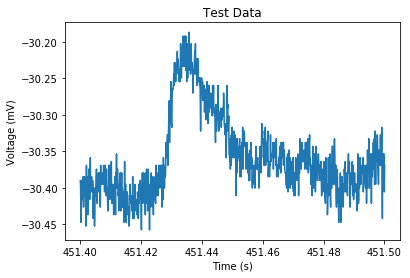

In [2]:
#our package import
import neuronal

single_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('single_PSP_data.txt'), num_psp=1)

#Plot the data to guess the parameters
plt.plot(single_psp.data['T'], single_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

## Parameter estimation

psp_fit performs Hamiltonian MC parameter estimation using a NUTS sampler. This converges best when a reasonable initial guess is supplied.

| Parameter | Description |
|------|------|
| b | constant baseline value |
| sigma | width of Gaussian noise |
| a0, a1, a2 etc. | amplitude of each PSP |
| t_psp0, t_psp1 etc. | start time of each PSP |
| tau_d0, tau_d1 etc. | decay time constant of each PSP |
| tau_r0, tau_r1 etc. | rise time constant of each PSP |

In [3]:
#The function behind the scenes
neuronal.psp_fit??

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r0, tau_d0, t_psp0, a0, sigma, b]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:37<00:00, 79.39draws/s] 
The acceptance probability does not match the target. It is 0.8845743712366286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807179668686089, but should be close to 0.8. Try to increase the number of tuning steps.


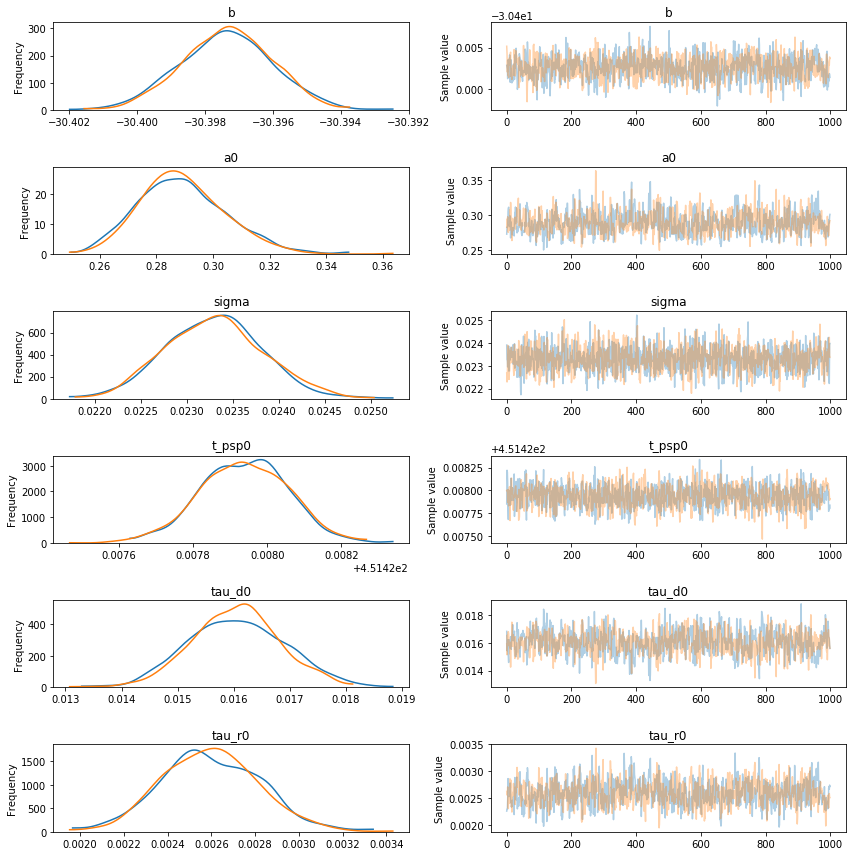

In [11]:
#Perform parameter estimation
initial_guess = {'b': -30.39, 'sigma': 0.023303, 'a0': 0.3, 't_psp0': 451.43, 'tau_d0': 0.01, 'tau_r0': 0.001}
sample = neuronal.psp_fit(single_psp, 1000, initial_guess)

In [12]:
summary = pm.summary(sample)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,-30.397377,0.001327,0.000043,-30.399944,-30.394799,940.485550,0.999717
a0,0.289237,0.015376,0.000583,0.260501,0.318598,643.494225,0.999513
sigma,0.023293,0.000522,0.000013,0.022366,0.024397,1409.651868,0.999654
t_psp0,451.427937,0.000117,0.000003,451.427683,451.428143,1247.625990,0.999735
tau_d0,0.016037,0.000819,0.000030,0.014507,0.017655,659.594953,0.999769
tau_r0,0.002594,0.000222,0.000008,0.002184,0.003044,732.773593,0.999559


## Plotting results

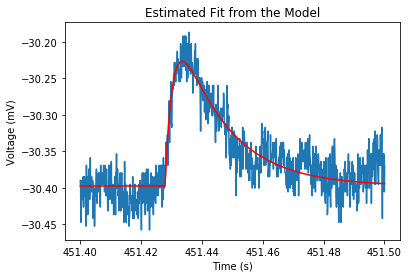

In [13]:
neuronal.plot_fit(single_psp, sample)

It appears like our simplest model works when the baseline is reasonably flat and when the only signal present is a PSP signal.

## Example: Multiple PSPs

Now, let's see if our simplest model can work for multiple PSP peaks when the baseline is reasonably flat.

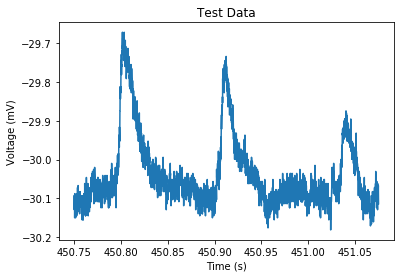

In [8]:
three_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('three_PSP_data.txt'), num_psp=3)

#Plot the data to guess the parameters
plt.plot(three_psp.data['T'], three_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r2, tau_r1, tau_r0, tau_d2, tau_d1, tau_d0, t_psp2, t_psp1, t_psp0, a2, a1, a0, sigma, b]
Sampling 2 chains: 100%|██████████| 3000/3000 [19:17<00:00,  1.08s/draws]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


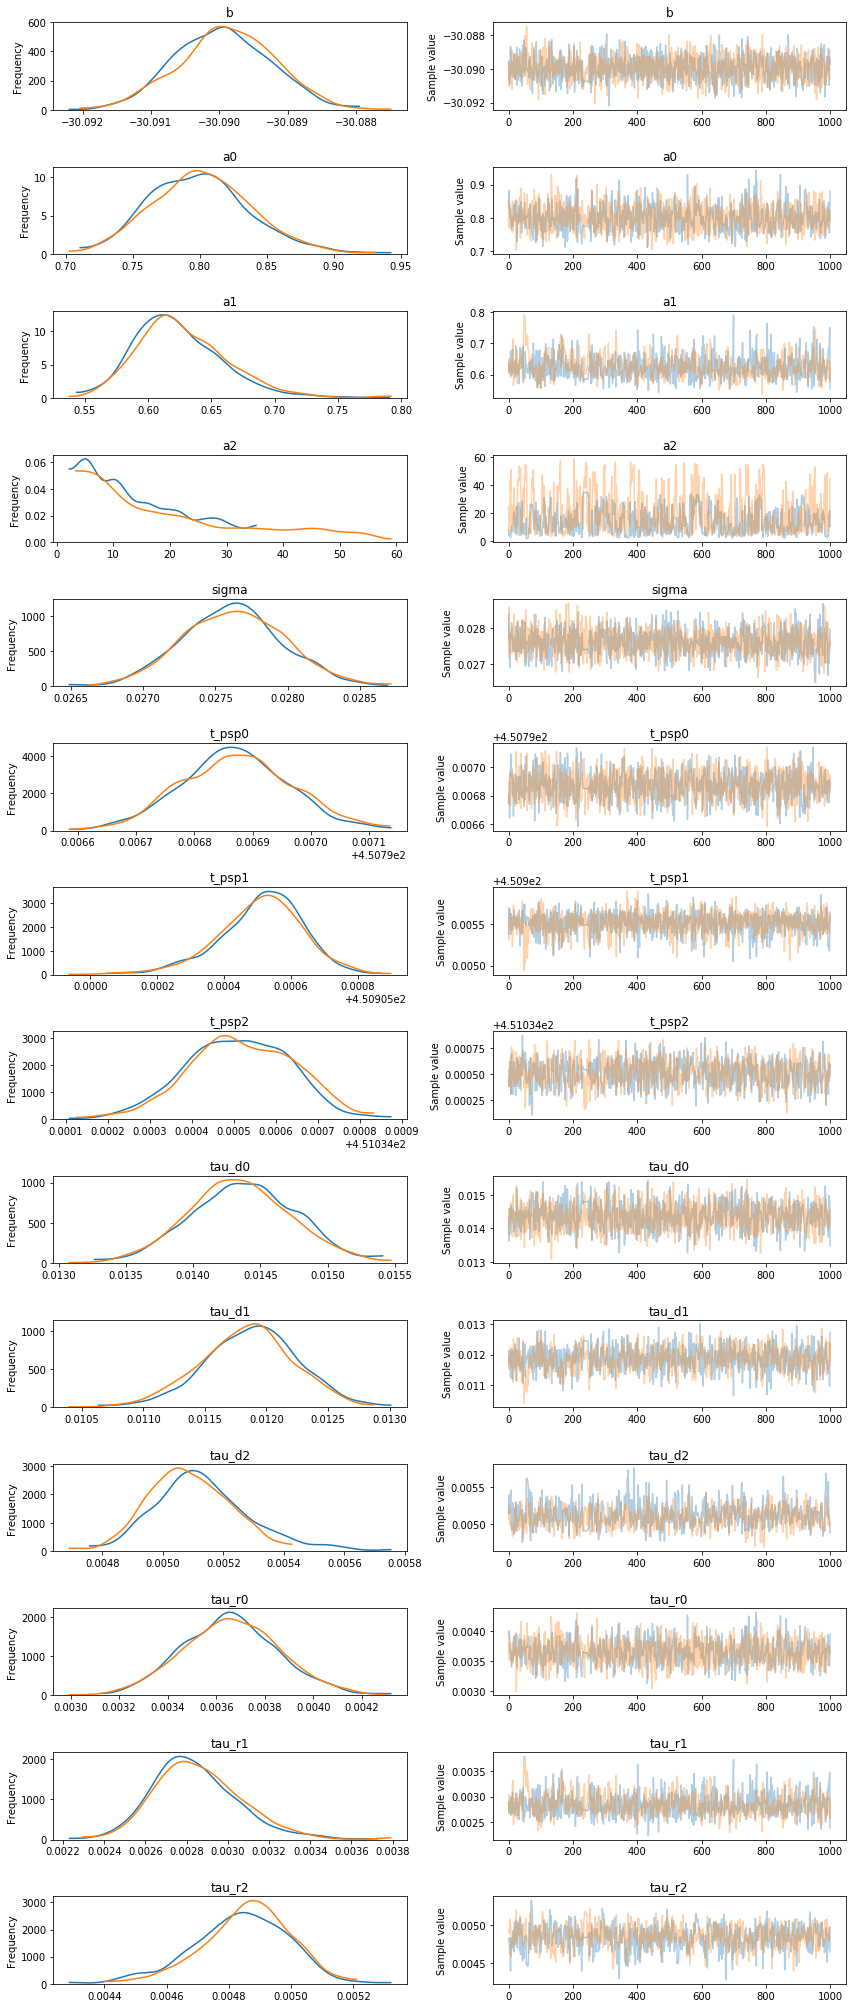

In [9]:
#Perform parameter estimation
initial_guess = {'b': -30.08, 'sigma': 0.027629, 'a0': 0.8, 't_psp0': 450.78, 'tau_d0': 0.01, 'tau_r0': 0.001,
                 'a1': 0.6, 't_psp1': 450.90, 'tau_d1': 0.01, 'tau_r1': 0.001,
                 'a2': 19, 't_psp2': 451.03, 'tau_d2': 0.005, 'tau_r2': 0.001
                }

sample3 = neuronal.psp_fit(three_psp, 1000, initial_guess)

In [16]:
summary3 = pm.summary(sample3)
summary3

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,-30.089930,0.000690,0.000019,-30.091194,-30.088538,1215.239176,1.002440
a0,0.800686,0.037181,0.001106,0.727138,0.871716,1114.073370,1.000331
a1,0.625461,0.035460,0.001450,0.562498,0.696652,478.871908,1.003504
a2,17.064483,12.533811,0.628704,2.294770,45.071150,44.647564,1.067028
sigma,0.027618,0.000346,0.000010,0.026908,0.028236,1398.023810,1.000302
t_psp0,450.796870,0.000094,0.000003,450.796697,450.797068,1318.096592,1.000277
t_psp1,450.905508,0.000125,0.000004,450.905263,450.905767,891.381868,1.000188
t_psp2,451.034513,0.000122,0.000003,451.034283,451.034743,876.992332,1.002318
tau_d0,0.014358,0.000383,0.000011,0.013624,0.015117,1199.652426,1.001723
tau_d1,0.011855,0.000374,0.000014,0.011104,0.012562,577.118846,1.004517


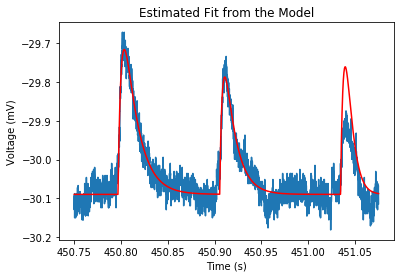

In [18]:
neuronal.plot_fit(three_psp, sample3)

Our simplest model fits reasonably well, but for the last peak, our estimate has a higher peak amplitude than the actual peak. In future updates, we will modify our model by changing the baseline after each spike.

# New Generative Model for PSP's

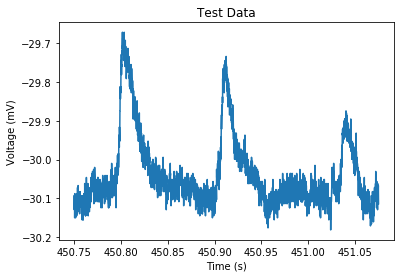

In [7]:
three_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('three_PSP_data.txt'), num_psp=3)

#Plot the data to guess the parameters
plt.plot(three_psp.data['T'], three_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b_end, b, b_start]
Sampling 2 chains: 100%|██████████| 1600/1600 [11:23<00:00,  1.19draws/s]
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


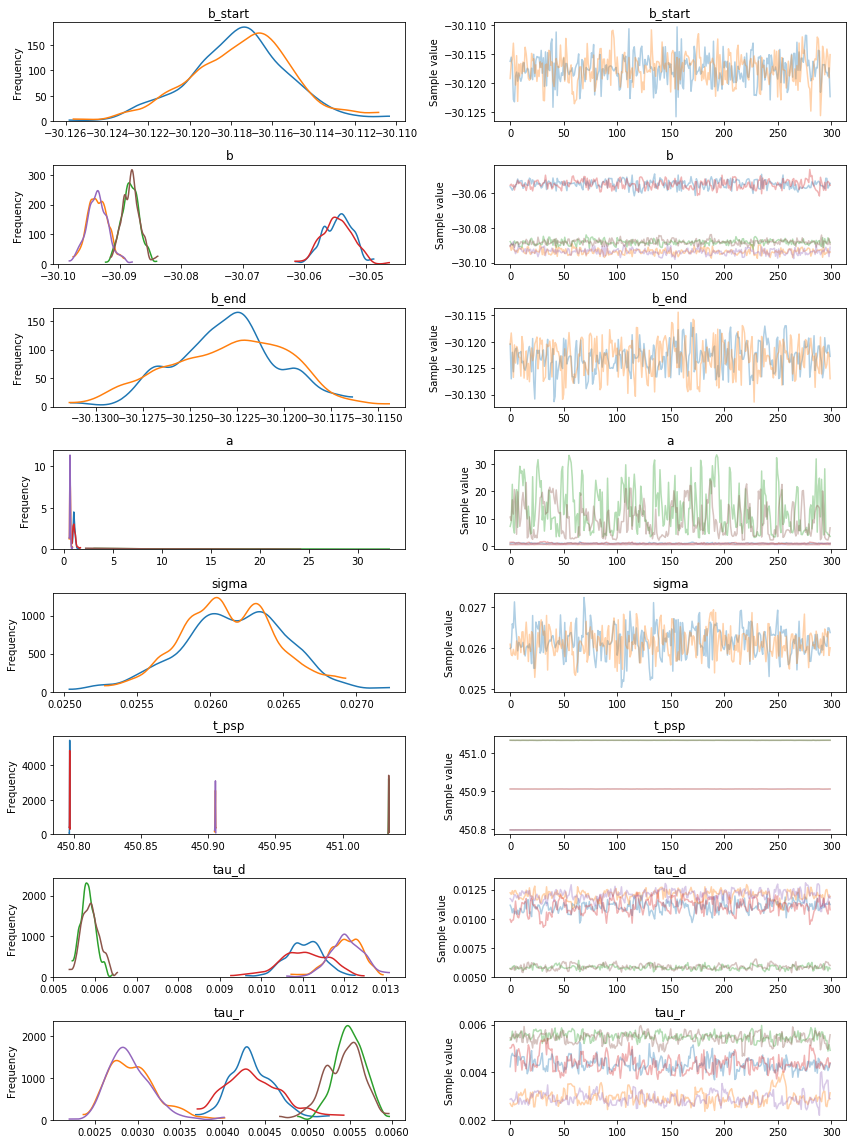

In [4]:
#Perform parameter estimation

initial_guess = {'sigma': 0.026, 'b_start': -30.1, 'b': [-30.05, -30.1, -30.1], 'b_end': -30.1,
                 'a': [0.8, 0.6, 15], 't_psp': [450.78, 450.90, 451.03], 'tau_d': [0.01, 0.01, 0.005361], 
                 'tau_r': [0.001, 0.001, 0.005206]
                }

sample3 = neuronal.psp_fit(three_psp, 300, initial_guess)

In [10]:
summary3 = pm.summary(sample3)
summary3

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_start,-30.117548,0.002465,0.000110,-30.123041,-30.113121,471.972715,0.999413
b__0,-30.054625,0.002381,0.000119,-30.058929,-30.050252,385.212038,0.999228
b__1,-30.093616,0.001673,0.000082,-30.097111,-30.090466,393.654767,0.998683
b__2,-30.088204,0.001421,0.000071,-30.090873,-30.085332,306.378890,0.999224
b_end,-30.123007,0.002965,0.000134,-30.128923,-30.117619,413.684668,0.998344
a__0,1.060731,0.136874,0.008860,0.839907,1.322595,144.044801,1.002759
a__1,0.634784,0.044047,0.003269,0.561414,0.716271,112.307632,1.003959
a__2,11.534968,7.457716,0.495874,2.220716,26.609866,63.510706,1.065252
sigma,0.026141,0.000349,0.000016,0.025499,0.026861,415.523152,1.001063
t_psp__0,450.797142,0.000079,0.000004,450.796992,450.797285,278.162310,0.999903


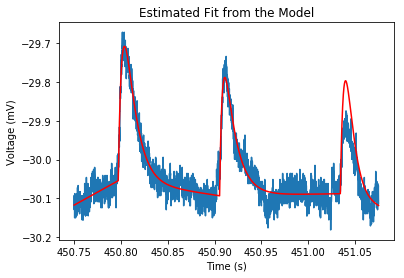

In [9]:
neuronal.plot_fit(three_psp, sample3)